Introduction

This notebook demonstrates how to apply CatBoost, a gradient boosting algorithm from Yandex, on a purely categorical, high-cardinality dataset — Cat in the Dat Kaggle.

Unlike most ML models that require extensive encoding (one-hot, label encoding, etc.), CatBoost can natively process categorical variables through its internal ordered target encoding mechanism.

About the Dataset

Source: Kaggle – Cat in the Dat Competition

Rows: 300,000

Features: 24 (almost all categorical)

Objective: Binary classification (target = 0 or 1)

Challenge: High cardinality (hundreds of unique values in some columns)

My Project Goal

The goal here isn’t to maximize accuracy,precision or recall  but to demonstrate CatBoost handling of categorical data efficiently and cleanly, without the need for massive manual encoding or feature engineering.

 Why Keep the Dataset Large

I deliberately did not reduce the number of rows too much during training.
Here is my reason

Reducing the dataset size would reduce cardinality (unique category counts per column).

CatBoost’s main advantage appears when category levels are many — it learns category impact via target statistics.

Sampling aggressively (e.g., 10%) might make it faster, but it would undermine CatBoost’s strength in dealing with categorical diversity.

Hence, this notebook shows how CatBoost can handle large, messy categorical data even with moderate hardware (like Google Colab CPU).

I did however while Random search cv reduced data to 5 percent but original baseline model was trained on entire 300k dataset

In [ ]:
#Installing all required libraries CatBoost for modeling, scikit-learn for evaluation, pandas/numpy for data wrangling, seaborn/matplotlib for plots, shap for interpretability.

!pip install catboost scikit-learn pandas matplotlib seaborn kaggle shap -q

In [ ]:
from google.colab import files
files.upload()

#I downloaded the dataset from here https://www.kaggle.com/competitions/cat-in-the-dat/data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool
import shap

In [ ]:
#Loading the dataset and inspecting  shape/head to confirm structure.

df = pd.read_csv("train.csv")
print("Shape:", df.shape)


Shape: (300000, 25)


In [ ]:
 pd.set_option('display.max_columns', None)

In [ ]:
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [ ]:
df.target.value_counts()#imbalanced dataset

,count
target,
0,208236
1,91764


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      300000 non-null  int64 
 1   bin_0   300000 non-null  int64 
 2   bin_1   300000 non-null  int64 
 3   bin_2   300000 non-null  int64 
 4   bin_3   300000 non-null  object
 5   bin_4   300000 non-null  object
 6   nom_0   300000 non-null  object
 7   nom_1   300000 non-null  object
 8   nom_2   300000 non-null  object
 9   nom_3   300000 non-null  object
 10  nom_4   300000 non-null  object
 11  nom_5   300000 non-null  object
 12  nom_6   300000 non-null  object
 13  nom_7   300000 non-null  object
 14  nom_8   300000 non-null  object
 15  nom_9   300000 non-null  object
 16  ord_0   300000 non-null  int64 
 17  ord_1   300000 non-null  object
 18  ord_2   300000 non-null  object
 19  ord_3   300000 non-null  object
 20  ord_4   300000 non-null  object
 21  ord_5   300000 non-null  object
 

In [ ]:
print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False))
print("\nUnique values per column:\n", df.nunique().sort_values(ascending=False))# A very high cardinal dataset perfect for my catboost like feature  nom_9 has unique 11981 categories


Missing values per column:
 id        0
bin_0     0
bin_1     0
bin_2     0
bin_3     0
bin_4     0
nom_0     0
nom_1     0
nom_2     0
nom_3     0
nom_4     0
nom_5     0
nom_6     0
nom_7     0
nom_8     0
nom_9     0
ord_0     0
ord_1     0
ord_2     0
ord_3     0
ord_4     0
ord_5     0
day       0
month     0
target    0
dtype: int64

Unique values per column:
 id        300000
nom_9      11981
nom_8       2215
nom_7       1220
nom_6        522
nom_5        222
ord_5        192
ord_4         26
ord_3         15
month         12
day            7
nom_3          6
ord_2          6
nom_2          6
nom_1          6
ord_1          5
nom_4          4
ord_0          3
nom_0          3
bin_4          2
bin_3          2
bin_0          2
bin_1          2
bin_2          2
target         2
dtype: int64


In [ ]:
y = df['target']# my target column
X = df.drop(columns=['target', 'id'])  # Dropping redundant columns

In [ ]:
# Identifying  categorical columns (most columns are categorical)
cat_cols = [col for col in X.columns if X[col].dtype == 'object'] + \
           [col for col in X.columns if 'bin_' in col or 'nom_' in col or 'ord_' in col]


In [ ]:
# Fill NaNs in categorical columns with missing not unknown
for c in cat_cols:
    X[c] = X[c].astype('object').fillna('Missing')


**Train	70%	Model learning**

Validation	15%	Hyperparameter tuning / early stopping

Test	15%  My 	Final unbiased evaluation on this dataset

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [ ]:

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

Train: (210000, 23) Validation: (45000, 23) Test: (45000, 23)


#building  CatBoost Pool objects (which store feature like text ,categorrical or numerical).

In [ ]:
# CatBoost Pools (needed for categorical features)
cat_features = [X.columns.get_loc(c) for c in cat_cols]# segregating categorical columns
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(X_val, label=y_val, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

In this baseline model, I trained CatBoost on the entire 70% training dataset without applying any sampling or row reduction.
The reason for keeping all data intact is that CatBoost performs exceptionally well on high-cardinality categorical features, and reducing the dataset would have artificially lowered the category diversity within these columns.
Since this dataset contains several features with hundreds of unique categorical values, using the full training data ensures that CatBoost can fully leverage its ordered target encoding and categorical feature statistics.
This makes the baseline a true reflection of how CatBoost handles complex, high-cardinality categorical data  exactly what it was designed for.

If i feel from business parameter a column is extre,mely important i can use golden features

In [ ]:
help( CatBoostClassifier )

In [ ]:
# my baseline model ,Training  a basic CatBoost model with early stopping; default parameters already give strong results on categorical data.As per Yandex


baseline_model = CatBoostClassifier(
    iterations=500,  # number of boosting rounds (trees). More iterations may give  higher accuracy but slower.
    learning_rate=0.1,  #step size for each boosting iteration. Lower = slower but stable and  higher = faster but risk overfitting .
    depth=6,   # depth of each individual tree. Controls model complexity. Common range: 4–10 as per yandex
    loss_function='Logloss',# as binary classification
    eval_metric='AUC',  # evaluation metric  AUC is robust for imbalanced datasets I am focusing  on ranking separation classes  not raw accuracy
    #i could also use average precison or PR Auc that more sublime eval_metric='PRAUC'
    random_seed=42,# reproducibilty maintain
    logging_level='Verbose' # printing my training progress every few iterations.
)

baseline_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=100)

0:	test: 0.6913370	best: 0.6913370 (0)	total: 751ms	remaining: 6m 14s
100:	test: 0.7889511	best: 0.7889511 (100)	total: 1m 17s	remaining: 5m 4s
200:	test: 0.7920277	best: 0.7920540 (199)	total: 2m 35s	remaining: 3m 51s
300:	test: 0.7927422	best: 0.7927480 (297)	total: 4m 8s	remaining: 2m 44s
400:	test: 0.7930324	best: 0.7930533 (392)	total: 5m 31s	remaining: 1m 21s
499:	test: 0.7931719	best: 0.7931913 (496)	total: 6m 55s	remaining: 0us

bestTest = 0.7931913396
bestIteration = 496

Shrink model to first 497 iterations.


In [ ]:
 # My reusable function evaluates model performance on any dataset be it Validation or Test.


def evaluate_model(model, X, y, dataset_name="Validation"):# checking ob validation
    preds_proba = model.predict_proba(X)[:, 1] # predict_proba returns probability of positive class 1
    preds = (preds_proba >= 0.5).astype(int)
    print(f"\n {dataset_name} Results:")
    print("AUC:", roc_auc_score(y, preds_proba))# closr to 1 better the model
    print("Accuracy:", accuracy_score(y, preds))  # ACC
    print("Precision:", precision_score(y, preds))#precison
    print("Recall:", recall_score(y, preds))
    print("F1:", f1_score(y, preds))  # Harmonic mean of precision & recall I can even do f 0.5 if more precision focused or f 1.5 if more recall focused

    print("\nConfusion Matrix:\n", confusion_matrix(y, preds))
    print("\nClassification Report:\n", classification_report(y, preds))

evaluate_model(baseline_model, X_val, y_val, "Validation (Baseline)")


 Validation (Baseline) Results:
AUC: 0.793191339616354
Accuracy: 0.7566222222222222
Precision: 0.6572035319101375
Recall: 0.42717035960770067
F1: 0.5177879535047551

Confusion Matrix:
 [[28168  3067]
 [ 7885  5880]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84     31235
           1       0.66      0.43      0.52     13765

    accuracy                           0.76     45000
   macro avg       0.72      0.66      0.68     45000
weighted avg       0.74      0.76      0.74     45000



In [ ]:
#Doing hyper parameter tuning with 5 percent of original data as it was taking too much time 300k on GPU
# Instead of full 300k rows, use 5% to speed up RandomizedSearchCV.
# CatBoost handles full data well, but tuning all parameters on it
# would be unnecessarily slow.

from sklearn.model_selection import RandomizedSearchCV

print("i am sampling 5% of training data for faster tuning")
X_sample = X_train.sample(frac=0.05, random_state=42)
y_sample = y_train.loc[X_sample.index]
print(" Sample size:", X_sample.shape)

i am sampling 5% of training data for faster tuning
 Sample size: (10500, 23)


In [ ]:
# combination of parameters

param_dist = {
    'iterations': [200, 300],        # number of my  boosting rounds or trees
    'learning_rate': [0.03, 0.05],   # step size for weight update
    'depth': [4, 6],                 # tree depth controls complexity
    'l2_leaf_reg': [1, 3],           # L2 regularization term
    'bagging_temperature': [0, 0.5], # controls randomness of sampling  High randomness is  more diverse trees
    'random_strength': [0, 1, 2]     # random noise for split scoring prevents the model from always picking the exact same dominant feature
}

cv_split = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

cb_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    cat_features=cat_features,
    random_seed=42,
    logging_level='Silent'
)

rs = RandomizedSearchCV(
    estimator=cb_model,
    param_distributions=param_dist,
    n_iter=2,
    scoring='roc_auc',
    cv=cv_split,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print(" Running Randomized Search...")
rs.fit(X_sample, y_sample)
print("\n  Best params:")
print(rs.best_params_)
print("Best CV AUC:", rs.best_score_)

 Running Randomized Search...
Fitting 2 folds for each of 2 candidates, totalling 4 fits

  Best params:
{'random_strength': 2, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 6, 'bagging_temperature': 0.5}
Best CV AUC: 0.7379898271299448


In [ ]:
best_params = rs.best_params_

final_model = CatBoostClassifier(
    **best_params,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    logging_level='Verbose'
)

final_model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50, verbose=100)
evaluate_model(final_model, X_test, y_test, "Test (Final)")

0:	test: 0.6827701	best: 0.6827701 (0)	total: 798ms	remaining: 2m 38s
100:	test: 0.7812485	best: 0.7812485 (100)	total: 1m 21s	remaining: 1m 20s
199:	test: 0.7889165	best: 0.7889165 (199)	total: 2m 37s	remaining: 0us

bestTest = 0.7889164984
bestIteration = 199


📊 Test (Final) Results:
AUC: 0.7930687083239041
Accuracy: 0.7585777777777778
Precision: 0.6907894736842105
Recall: 0.3814298169136879
F1: 0.49148099606815204

Confusion Matrix:
 [[28886  2350]
 [ 8514  5250]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.92      0.84     31236
           1       0.69      0.38      0.49     13764

    accuracy                           0.76     45000
   macro avg       0.73      0.65      0.67     45000
weighted avg       0.75      0.76      0.73     45000



Please note the objective of this project was not to chase the highest precision or recall scores, but to demonstrate how CatBoost naturally handles high-cardinality categorical data without heavy preprocessing.
While extended hyperparameter tuning or randomized search could further optimize the metrics, the goal here was to showcase CatBoost’s categorical encoding and ordered boosting capabilities rather than exhaustively fine-tune performance.

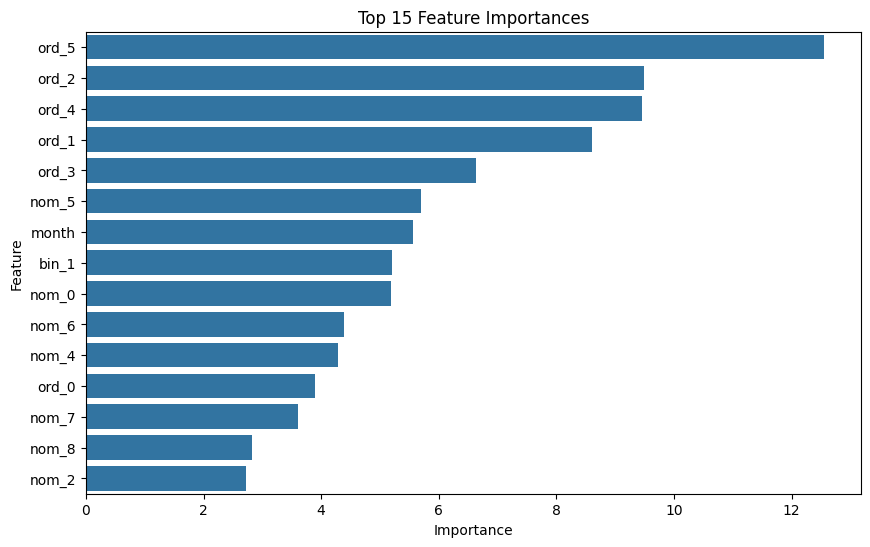

In [ ]:
# CatBoost computes importance from the total gain across splits.

# High values refers to features that helped most during splitting   in reducing loss# Feature importances
importances = final_model.get_feature_importance(train_pool)
imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=imp_df.head(15))
plt.title('Top 15 Feature Importances')
plt.show()


Please note The feature importance values in CatBoost indicate how much each feature helps in reducing the overall loss during training , essentially, how much that feature contributes to improving the models performance or increasing gain(by enabling each split (node) reduces the loss)

Also its important to understand that these importances dont mean the feature is pushing predictions toward 0 or 1 directly. Instead, they represent how strongly each feature helps split the data in a way that reduces the model residual error.

CatBoost computes these importance scores using the gradients and Hessians (first and second derivatives) of the loss function — not traditional metrics like information gain or Gini impurity used in classical decision trees. So, the importance reflects contribution to loss minimization, not the direction (positive or negative) of influence.

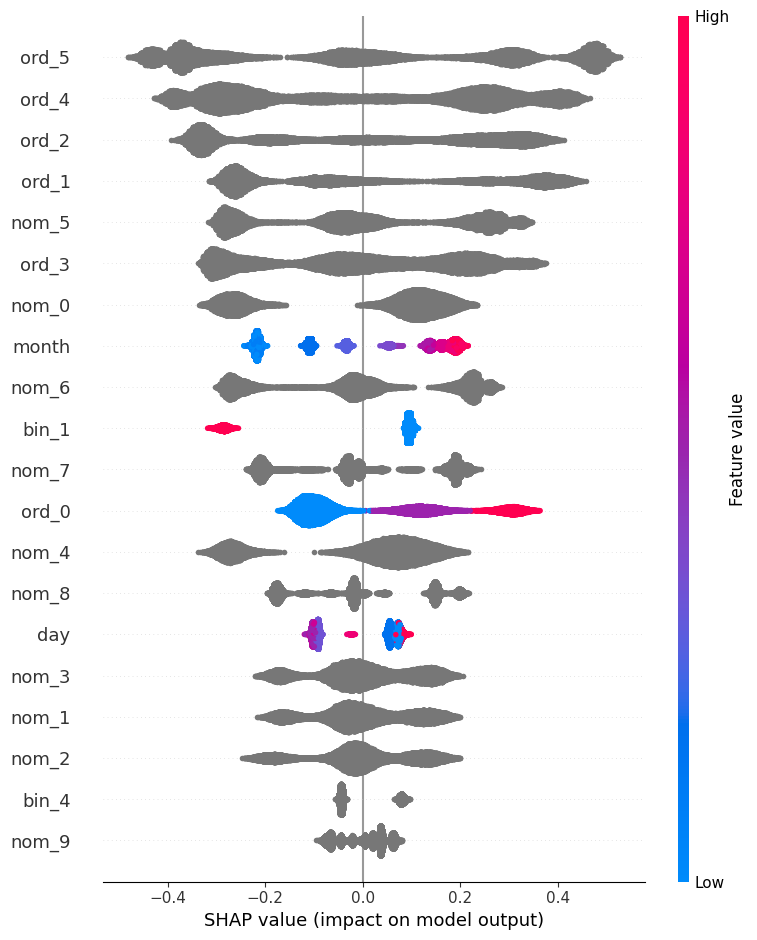

In [ ]:

# SHAP explanation (optional)
shap_values = final_model.get_feature_importance(type='ShapValues', data=test_pool)
shap.summary_plot(shap_values[:,:-1], X_test)

Some SHAP values appear grey because several features in this dataset have very high cardinality  which means they contain a large number of unique categories. These features are categorical, not continuous, so SHAP cant easily assign a smooth color gradient like it does for numeric variables. Instead, CatBoost internally converts these categorical features into ordered target encodings
Like(  current count +Hyperparameter)/ MAX  count =1 ,where target is1 target driven. after shuffling data to prevent data leakage The value will be somewhat equivalemt to 1 or less

In [ ]:
#saving model

import joblib

joblib.dump(final_model, '/content/catboost_cat_in_dat.pkl')
print(" Model saved as catboost_cat_in_dat.pkl")

 Model saved as catboost_cat_in_dat.pkl


In [ ]:
from google.colab import files
files.download('/content/catboost_cat_in_dat.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = joblib.load('catboost_cat_in_dat.pkl')

###This project demonstrated how CatBoost can elegantly handle complex, highcardinality categorical data without explicit preprocessing.

My Key takeaways

Baseline model: Achieved strong AUC (~0.79) using raw categorical features — no encoding or scaling.

Data splitting: Used a 70-15-15 train/val/test stratified split for robust evaluation.

No downsampling: Retaining full data preserved category diversity — essential for CatBoost’s ordered encodings.

Hyperparameter tuning: A lightweight Randomized Search on 5% of the data optimized depth, learning rate, and regularization.

Final performance: A balanced model with good AUC, recall, and explainability.

Interpretability

Feature importances highlighted key categorical drivers.

SHAP explained individual contributions — with grey areas signaling low-impact or unordered categorical encodings. ###
